##Install & import important packages..
Packages used:
1. PyTorch
2. OpenCV
3. Diffusers
4. Transformers
5. NumPy

In [ ]:
!pip install diffusers
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.8/934.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.2 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
import torch
from PIL import Image
from torch.cuda.amp import autocast
from diffusers import AutoencoderKL, UNet2DConditionModel, UNet2DModel, StableDiffusionImg2ImgPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler

import time
import zlib
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

##Connect to Huggingface and download Stable Diffusion model
In order to download the Stable Diffusion model, you have to create a free account on the huggingface.com website and then create an access token here: https://huggingface.co/settings/tokens

After that, copy the access token to the field of the settings cell.

Additionally, you also have to accept the Stable Diffusion usage license by accepting it here: https://huggingface.co/CompVis/stable-diffusion-v1-4

Otherwise the following Cell will fail

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

##Install pretrained models
Models used-
1. Variational Auto Encoder
2. UNet 
3. Text Encoder
4. Tokenizer

In [ ]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae", use_auth_token=True
).to(torch_device)

unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", use_auth_token=True
).to(torch_device)

scheduler = PNDMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
    num_train_timesteps=1000, skip_prk_steps=True
)

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True,
)

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
    #revision=pretrained_model_revision, torch_dtype=torch.float16
)

uncond_input = tokenizer([""], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids)[0].to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


##Helper Methods

Methods used for compression:
1. make_latents:\
converts the images to latent representation with the help of Variational Autoencoders (VAE).

2. make_image:\
Decodes the latent representation and converts the image to a PIL Image.

3. resize:\
Crops and resizes the image to 512x512 image size.

In [ ]:
@torch.no_grad()

def make_latents(img):
  """Makes latent representations of images using Variational Auto Encoder"""
  #Scale down and normalize the image from [-1, 1]
  np_img = (np.array(img).astype(np.float32) / 255.0) * 2.0 - 1.0
  # Adding extra dimension "None" and rearranging to the format (None, 3, height, width)
  np_img = np_img[None].transpose(0, 3, 1, 2)
  torch_img = torch.from_numpy(np_img)
  with autocast():
    generator = torch.Generator("cuda").manual_seed(0)
    latents = vae.encode(torch_img.to(vae.dtype).to(torch_device)).latent_dist.sample(generator=generator)
  return latents

In [ ]:
@torch.no_grad()
def make_image(latents):
  """Decode the latent representation and convert the image to a PIL image"""
  with autocast():
    torch_img = vae.decode(latents.to(vae.dtype).to(torch_device)).sample
  torch_img = (torch_img / 2 + 0.5).clamp(0, 1)
  np_img = torch_img.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
  np_img = (np_img * 255.0).astype(np.uint8)
  img = Image.fromarray(np_img)
  return img

In [ ]:
@torch.no_grad()
def resize(input_file, output_file):
  img = Image.open(input_file).convert('RGB')
  #Determine the top left and top right corner of the croppped image and then crop the image with these coordinates
  maxdim = max(img.width, img.height)
  mindim = min(img.width, img.height)
  left = max(0, (img.width - img.height) // 2 - 1)
  top = max(0, (img.height - img.width) // 2 - 1)
  img = img.crop((left, top, left + mindim - 1, top + mindim - 1))
  #Resize the cropped image to 512x512 image size
  img = img.resize((512,512), Image.LANCZOS)
  img.save(output_file, lossless = True, quality = 100)

In [ ]:
def quantize(latents):
  """Changes the continuous colours of an image to a dscrete colour """
  quantized_latents = (latents / (255 * 0.18215) + 0.5).clamp(0,1)
  quantized = quantized_latents.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
  quantized = (quantized * 255.0 + 0.5).astype(np.uint8)
  return quantized

In [ ]:
def unquantize(quantized):
  """Unquantizes the quantized latents and converts them to array format that can be passed on to a generative model"""
  unquantized = quantized.astype(np.float32) / 255.0
  unquantized = unquantized[None].transpose(0, 3, 1, 2)
  unquantized_latents = (unquantized - 0.5) * (255 * 0.18215)
  unquantized_latents = torch.from_numpy(unquantized_latents)
  return unquantized_latents.to(torch_device)

In [ ]:
@torch.no_grad()
def denoise(latents):  
  """Denoise image with the help of a UNet architecture by predicting the noise in every 
  iteration in the schedular loop and then updating the latent with the 
  noise accordingly."""
  latents = latents * 0.18215
  step_size = 15
  num_inference_steps = scheduler.config.get("num_train_timesteps", 1000) // step_size
  strength = 0.04
  scheduler.set_timesteps(num_inference_steps)
  offset = scheduler.config.get("steps_offset", 0)
  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)
  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps], dtype=torch.long, device=torch_device)
  extra_step_kwargs = {}
  
  latents = latents.to(unet.dtype).to(torch_device)
  t_start = max(num_inference_steps - init_timestep + offset, 0)
  with autocast():
    for i, t in enumerate(scheduler.timesteps[t_start:]):
      noise_pred = unet(latents, t, encoder_hidden_states=uncond_embeddings).sample
      latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

  scheduler.set_timesteps(1)
  return latents / 0.18215

##Compress
The image is passed to the make_latent function..

The generated latent representation is then saved in a webp format that reduces its size.

The compressed image can then be reconstructed 

In [ ]:
def main(input_file, output_path):
  img = Image.open(input_file)
  print("Ground Truth:  " + str(os.path.getsize(input_file)) + " Bytes")
  display(img)

  latents = make_latents(img)
  img_latent = make_image(latents)
  print("")
  print("Image from one latent roundtrip")
  display(img_latent)

  quantized = quantize(latents)
  quantized_img = Image.fromarray(quantized)
  quantized_img.save(output_path + "_sd_quantized_latents.webp", lossless=True, quality=100)
  print("Quantized Image")
  display(quantized_img)


  unquantized_latents = unquantize(quantized)
  unquantized_latents= denoise(latents=unquantized_latents)
  denoised_latent = denoise(unquantized_latents)
  unquantized_img = make_image(denoised_latent)
  print("")
  print("Image from the saved stable diffusion webp format:  " + str(os.path.getsize(output_path + "_sd_quantized_latents.webp")) + " Bytes")
  
  display(unquantized_img)
  

mkdir: cannot create directory ‘output_folder’: File exists
--2023-04-28 12:22:02--  https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?ixlib=rb-4.0.3
Resolving images.unsplash.com (images.unsplash.com)... 146.75.78.208, 2a04:4e42:83::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.78.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2081545 (2.0M) [image/jpeg]
Saving to: ‘photo-1477959858617-67f85cf4f1df?ixlib=rb-4.0.3’

photo-1477959858617 100%[===================>]   1.98M  --.-KB/s    in 0.06s   

2023-04-28 12:22:02 (32.9 MB/s) - ‘photo-1477959858617-67f85cf4f1df?ixlib=rb-4.0.3’ saved [2081545/2081545]

Ground Truth:  209874 Bytes


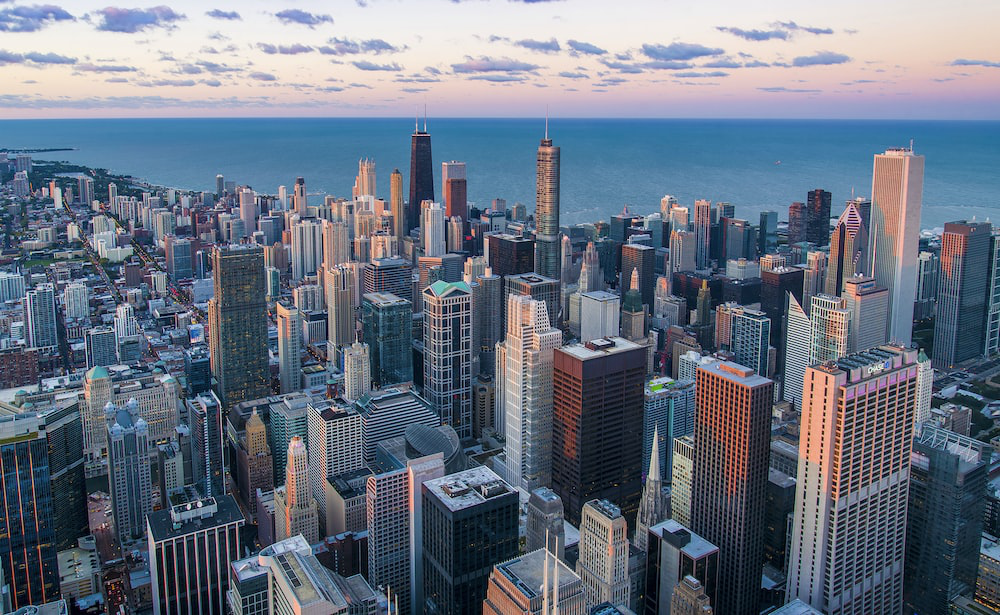


Image from one latent roundtrip


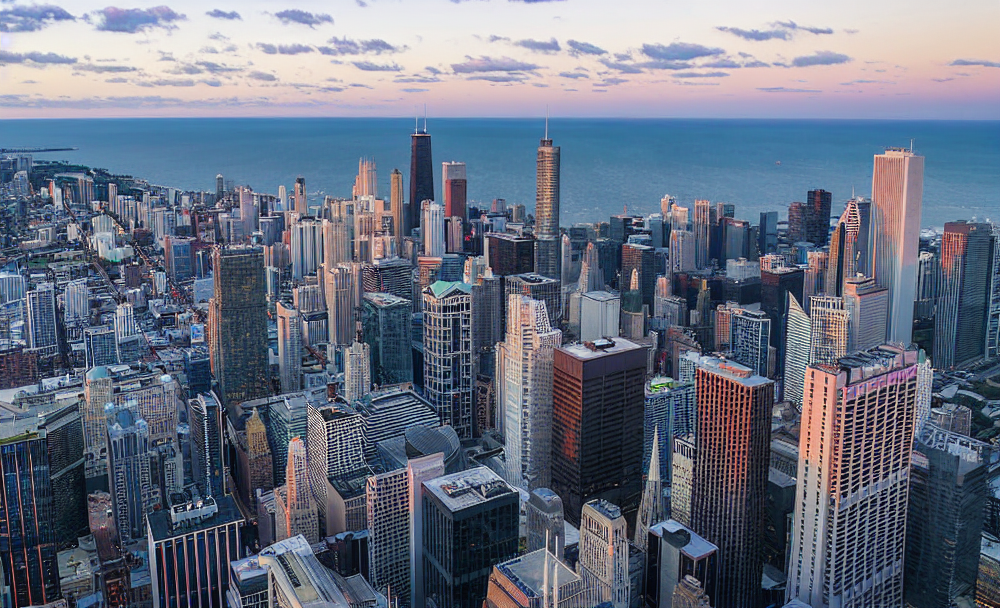

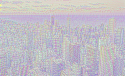


Image from the saved stable diffusion webp format:  30478 Bytes


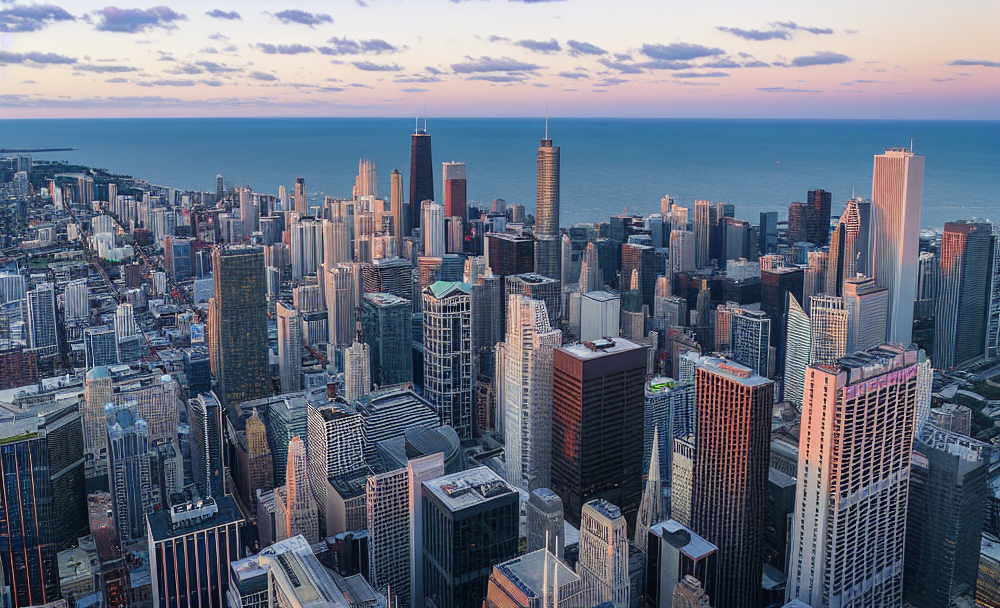

In [ ]:
!mkdir output_folder
!wget https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8Y2l0eXxlbnwwfHwwfHw%3D&w=1000&q=80
main("/content/photo-1477959858617-67f85cf4f1df?ixlib=rb-4.0.3", "/content/output_folder/")

References:

https://pub.towardsai.net/stable-diffusion-based-image-compresssion-6f1f0a399202